In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
## Reading in the data:


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld2 setup
run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
print(os)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
<xarray.Dataset>
Dimensions:        (Interface: 16, Layer: 15, Time: 7082)
Coordinates:
  * Layer          (Layer) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * Interface      (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03
  * Time           (Time) float64 0.0 5.0 10.0 ... 3.249e+04 3.25e+04 3.25e+04
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  ./ocean.stats.nc


In [3]:
lat=  np.array(av.yh)     #np.array(fs['geolon']); 
lon=  np.array(av.xh)     #fs['geolat']
area= np.array(fs['area_t'])

u= av.u[:,0,:,:]-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]-(av.v[:,0,:,:].mean('time'))
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
#dx = xr.DataArray(data=fs.dxCu.isel(xq=slice(0,len(lon))),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

(100, 2240, 960) (100, 2240, 960)


In [ ]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/16)
print('max dx:',2*np.pi*6378000/360/16)

In [ ]:
Ld = av.Rd1[:].mean('time')
Ld.shape
dx.shape

In [ ]:
plt.rcParams.update({'font.size': 18})

In [ ]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE density',fontsize=14)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon,lat,KE[-1,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

## We will now interpolate onto an X,Y grid (2D, irregular) and then onto a uniformly spaced X,Y grid with a resolution of 5km. In the 1/16 degree case the smallest grid spacing was 7km.

In [52]:
OGx=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.
OGy=dy.cumsum(axis=0)-dy[0,:]

OGx=(OGx-OGx[:,479]) #Center the grid along the center longitude.
OGy=(OGy-OGy[1119,:]) #Center the grid along the center latitude
dxnew = 5000; #meters; x coordinates range from -3340km to 3332km
dynew = 5000; #meters; y coordinates range from -7792 kmto 7785km

x5km = np.arange(-3330e3,3334e3,dxnew)
y5km = np.arange(-7785e3,7792e3,dynew)

# #Using example here: http://christopherbull.com.au/python/scipy-interpolate-griddata/
# #old grid dim
xi=np.array(OGx)
yi=np.array(OGy)


# #create mesh
Xnew, Ynew = np.meshgrid(x5km,y5km)



In [96]:
x1= -1750e3; x2=-x1;
#y1= -7000e3; y2= 7000e3; #defining slices in latitude that will be 100km or 20 grid points tall

nk = int((x2-x1)/(1000*5*2))
ny = 3116
#3116 is number of points in y
#300 is number of frequencies for an x domain of 600 points

u_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(u[0,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
v_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(v[0,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
u_regular = xr.DataArray(u_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
v_regular = xr.DataArray(v_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])

u_small=u_regular.sel(x5km=slice(x1, x2)).fillna(0.)
v_small=v_regular.sel(x5km=slice(x1, x2)).fillna(0.)


uiso2 = xrft.power_spectrum(u_small,dim=['x5km'], detrend='linear',window='hann').compute() #, window='hamming', detrend='linear'
viso2 = xrft.power_spectrum(v_small,dim=['x5km'],detrend='linear',window='hann').compute()
ekeiso = .5*(uiso2 + viso2)
    
wavenumber= (ekeiso.freq_x5km*1e3*2*np.pi)[nk+1:]
#print(wavenumber)

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

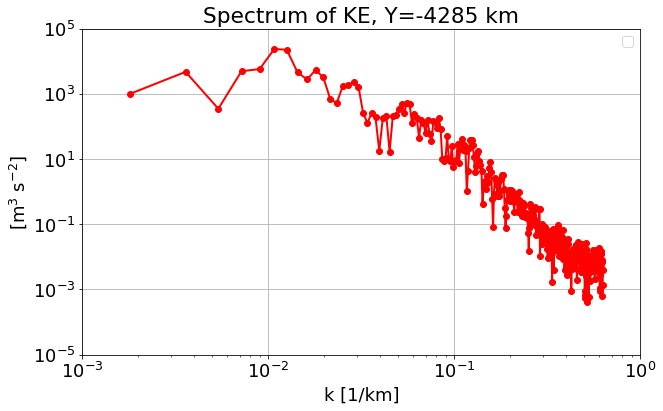

In [97]:
fig, ax = plt.subplots(figsize=(10,6))

#yindex=2000
yindex=700
y_position=u_small[yindex,0].y5km/1000

plt.plot(wavenumber,(ekeiso[yindex,nk+1:]),'-or',linewidth=2)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f km'%y_position)
plt.ylim([1e-5, 1e5])
plt.xlim([1e-3, 1e0])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [63]:
ekeiso.shape


(3116, 401)

### Computing the spectrum over many time steps:

In [ ]:
x1= -1750e3; x2=-x1;
#y1= -7000e3; y2= 7000e3; #defining slices in latitude that will be 100km or 20 grid points tall


nk = int((x2-x1)/(1000*5*2))
ny = 3116
#3116 is number of points in y
#300 is number of frequencies for an x domain of 600 points
tmax = 15
LD_wavenumber = np.zeros([tmax,ny])
wavenumber = xr.DataArray(np.zeros([tmax,nk]))
power=0*xr.DataArray(np.zeros([tmax,ny,nk]), coords=[np.arange(0,tmax),ekeiso.y5km,ekeiso.freq_x5km[nk+1:]], dims=["time","y5km", "freq_x5km"])

for i in range(0,tmax):
    u_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(u[i,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
    v_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(v[i,:,:].fillna(0.)).flatten() , (Xnew,Ynew),method='linear')
    Ld_regular=scipy.interpolate.griddata((xi.flatten(),yi.flatten()),np.array(Ld).flatten() , (Xnew,Ynew),method='linear')


    u_regular = xr.DataArray(u_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
    v_regular = xr.DataArray(v_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])
    Ld_regular=xr.DataArray(Ld_regular, coords=[y5km,x5km], dims=["y5km", "x5km"])


    u_small=u_regular.sel(x5km=slice(x1, x2)).fillna(0.)
    v_small=v_regular.sel(x5km=slice(x1, x2)).fillna(0.)
    Ld_small=Ld_regular.sel(x5km=slice(x1, x2))


    uiso2 = xrft.power_spectrum(u_small,dim=['x5km'], detrend='linear',window='hann').compute() #, window='hamming', detrend='linear'
    viso2 = xrft.power_spectrum(v_small,dim=['x5km'], detrend='linear',window='hann').compute()
    ekeiso = .5*(uiso2 + viso2)
    
    wavenumber[i,:]= (ekeiso.freq_x5km*1e3*2*np.pi)[nk+1:]
    power[i,:,:]= (ekeiso[:,nk+1:]) 
    LD_wavenumber[i,:]=np.nanmean(1/(Ld_small/1000),axis=1)


    print(i)
wavenumber=np.mean(wavenumber,axis=0)
Energetic_wavenumber=(power[:,:,2:].mean('time')).idxmax(dim='freq_x5km')*1000*2*np.pi #we don't allow the first three wavenumbers (roughly 300,500,1000km)
LD_wavenumber = np.nanmean(LD_wavenumber,axis=0)


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


0
1
2
3
4
5
6
7
8
9
10
11
12


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


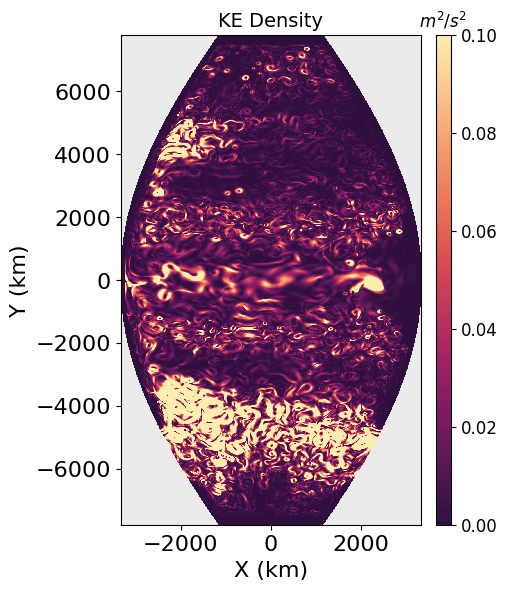

In [54]:
from matplotlib.patches import Rectangle
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('X (km)',fontsize=16)
ax1.set_ylabel('Y (km)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE Density',fontsize=14)

plotted =ax1.pcolor(Xnew/1000,Ynew/1000,0.5*(u_regular**2+v_regular**2),cmap=cmocean.cm.matter_r,vmin=0,vmax=.1)
#ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
ax2.set_title('$m^2/s^2$',fontsize=12)

plt.show()

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

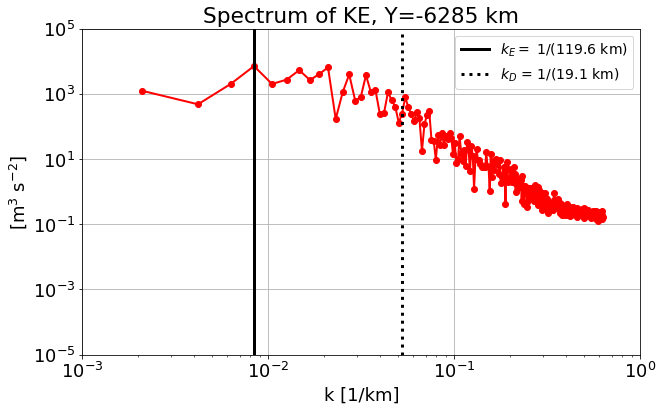

In [83]:
fig, ax = plt.subplots(figsize=(10,6))

#yindex=2000
yindex=300
y_position=u_small[yindex,0].y5km/1000
EW= (Energetic_wavenumber[yindex])
LW= (LD_wavenumber[yindex])

plt.plot(wavenumber,(power[:,yindex,:]).mean('time'),'-or',linewidth=2)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
l1=plt.plot([EW,EW], [1e-5,1e5],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/EW))
l2=plt.plot([LW,LW], [1e-5,1e5],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LW))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f km'%y_position)
plt.ylim([1e-5, 1e5])
plt.xlim([1e-3, 1e0])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

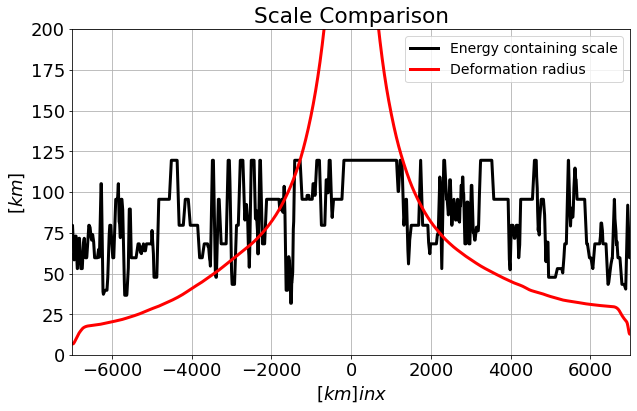

In [95]:

fig, ax = plt.subplots(figsize=(10,6))


#plt.plot(u_small.y5km/1000,1./Energetic_wavenumber,'-k',linewidth=2,label='Energy containing scale')
#plt.plot(u_small.y5km/1000,1./LD_wavenumber,'-r',linewidth=2,label='Deformation scale')  
window=10
plt.plot(u_small.y5km/1000,np.convolve(1./Energetic_wavenumber, np.ones((window,))/window, mode='same'),'-',c='k',linewidth=3,label='Energy containing scale')
plt.plot(u_small.y5km/1000,np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same'),'-',c='r',linewidth=3,label='Deformation radius')


plt.title('Scale Comparison')
plt.ylim([0, 200])
plt.xlim([-7000, 7000])
plt.grid()
plt.xlabel('$[km] in x$'); plt.ylabel('$[km]$');
plt.legend(fontsize=14)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

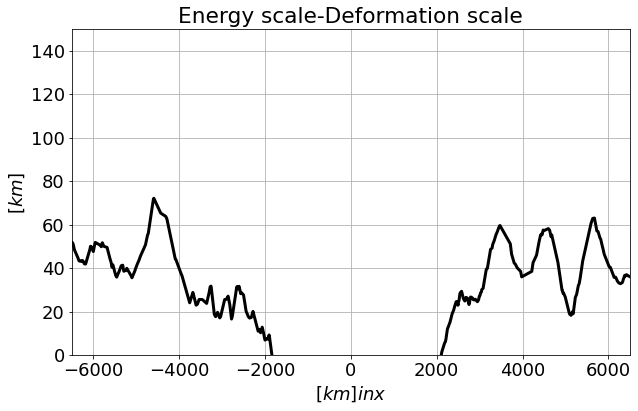

In [85]:

fig, ax = plt.subplots(figsize=(10,6))


#plt.plot(u_small.y5km/1000,1./Energetic_wavenumber,'-k',linewidth=2,label='Energy containing scale')
#plt.plot(u_small.y5km/1000,1./LD_wavenumber,'-r',linewidth=2,label='Deformation scale')  
window=100
a=np.convolve(1./Energetic_wavenumber, np.ones((window,))/window, mode='same')
b=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
plt.plot(u_small.y5km/1000,a-b,'-',c='k',linewidth=3,label='Energy containing scale')
#plt.plot(u_small.y5km/1000,np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same'),'-',c='r',linewidth=3,label='Energy containing scale')
#





plt.title('Energy scale-Deformation scale')
plt.ylim([0, 150])
plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('$[km] in x$'); plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

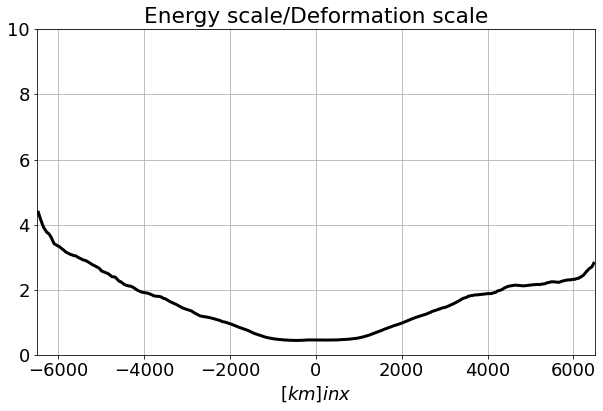

In [90]:
fig, ax = plt.subplots(figsize=(10,6))


#plt.plot(u_small.y5km/1000,1./Energetic_wavenumber,'-k',linewidth=2,label='Energy containing scale')
#plt.plot(u_small.y5km/1000,1./LD_wavenumber,'-r',linewidth=2,label='Deformation scale')  
window=500
a=np.convolve(1./Energetic_wavenumber, np.ones((window,))/window, mode='same')
b=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
plt.plot(u_small.y5km/1000,a/b,'-',c='k',linewidth=3,label='Energy containing scale')
#plt.plot(u_small.y5km/1000,np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same'),'-',c='r',linewidth=3,label='Energy containing scale')
#





plt.title('Energy scale/Deformation scale')
plt.ylim([0, 10])
plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('$[km] in x$'); 
#plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')